We need to generate the NERC map using a python library. To do this we will use the following python modules.  

In [16]:
import pathlib
import urllib.request
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

The NERC city data is located in the file city_data.csv, the first few lines of which are the following.

In [3]:
!head -n 5 city_data.csv

The first column _region_ is the NERC region name.  The column _name_ is the common name of the city. The column _code_ is the airport code of the city, which is used as the unique identifier when referencing the city.  This can be used to look up the city's location (although in some cases it may not the best location to map).  The _area_ is the name of the NERC load model area. The _climate_ column refers to the DOE climate zone.

To generate a map, we must load the data file(s) needed to download the data from the geopandas libraries.  At this point we state and zipcode maps. This process is only executed if the files have not already been downloaded.

In [4]:
states_filename = "tl_2017_us_state.zip"
states_url = f"https://www2.census.gov/geo/tiger/TIGER2017/STATE/{states_filename}"
states_file = pathlib.Path(states_filename)

zipcode_filename = "tl_2017_us_zcta510.zip"
zipcode_url = f"https://www2.census.gov/geo/tiger/TIGER2017/ZCTA5/{zipcode_filename}"
zipcode_file = pathlib.Path(zipcode_filename)

for data_file, url in zip([states_file, zipcode_file], [states_url, zipcode_url]):
    if not data_file.is_file():
        with urllib.request.urlopen(url) as resp, \
                open(data_file, "wb") as f:

            f.write(resp.read())

Once the file is downloaded, we can load the state and zipcode map data into memory and remove the unneeded columns.

In [10]:
states_gdf = gpd.read_file(f"zip://{states_file}")
for key in ["REGION","DIVISION","STATEFP","STATENS","GEOID","LSAD","MTFCC","FUNCSTAT","ALAND","AWATER","INTPTLAT","INTPTLON"]:
    del states_gdf[key]
states_gdf.set_index("STUSPS",inplace=True)
states_gdf.rename({"NAME":"Name"},axis="columns",inplace=True)
states_gdf.index.name = "State"

zipcode_gdf = gpd.read_file(f"zip://{zipcode_file}")
for key in ["ZCTA5CE10","CLASSFP10","MTFCC10","FUNCSTAT10","ALAND10","AWATER10","INTPTLAT10","INTPTLON10"]:
    del zipcode_gdf[key]
zipcode_gdf.set_index("GEOID10",inplace=True)
zipcode_gdf.index.name = "Zipcode"

Here is a preview of the zipcode data.

In [6]:
zipcode_gdf.head()

,geometry
Zipcode,
43451,"POLYGON ((-83.708733 41.327326, -83.708147 41...."
43452,"POLYGON ((-83.086978 41.537796, -83.0825629999..."
43456,"(POLYGON ((-82.835577 41.710823, -82.83515 41...."
43457,"POLYGON ((-83.49650299999999 41.253708, -83.48..."
43458,"POLYGON ((-83.222292 41.531025, -83.2222819999..."


Here is a preview of the state data.

In [11]:
states_gdf.head()

,Name,geometry
State,,
WV,West Virginia,"POLYGON ((-81.747254 39.095379, -81.746354 39...."
FL,Florida,"(POLYGON ((-82.987477 24.625379, -82.987477 24..."
IL,Illinois,"POLYGON ((-91.185295 40.637803, -91.1751 40.64..."
MN,Minnesota,"POLYGON ((-96.784381 46.63050399999999, -96.78..."
MD,Maryland,"POLYGON ((-77.45880799999999 39.22027, -77.458..."


Now we can assign the states and zipcodes to each reliability organization

In [32]:
nercdata = pd.read_csv("nerc_data.csv").set_index('State')
print(nercdata.head())
nerc_gdf = states_gdf.merge(nercdata,on='State')
nerc_gdf.head()

      NERCarea  ZipMin  ZipMax
State                         
ME        NPCC     NaN     NaN
VT        NPCC     NaN     NaN
NH        NPCC     NaN     NaN
MA        NPCC     NaN     NaN
NY        NPCC     NaN     NaN


,Name,geometry,NERCarea,ZipMin,ZipMax
State,,,,,
WV,West Virginia,"POLYGON ((-81.747254 39.095379, -81.746354 39....",RF,NaN,NaN
FL,Florida,"(POLYGON ((-82.987477 24.625379, -82.987477 24...",SERC,NaN,NaN
IL,Illinois,"POLYGON ((-91.185295 40.637803, -91.1751 40.64...",SERC,NaN,NaN
MN,Minnesota,"POLYGON ((-96.784381 46.63050399999999, -96.78...",MRO,NaN,NaN
MD,Maryland,"POLYGON ((-77.45880799999999 39.22027, -77.458...",RF,NaN,NaN


Now we can generate the base map of NERC reliability organizations.

In [96]:
bts_data = pd.read_csv("bts_airport_data.csv").set_index("AIRPORT")
bts_gdf = gpd.GeoDataFrame(bts_data,geometry=gpd.points_from_xy(bts_data.LONGITUDE,bts_data.LATITUDE))
bts_gdf.head()

,AIRPORT_SEQ_ID,AIRPORT_ID,DISPLAY_AIRPORT_NAME,DISPLAY_AIRPORT_CITY_NAME_FULL,AIRPORT_WAC,AIRPORT_COUNTRY_NAME,AIRPORT_COUNTRY_CODE_ISO,AIRPORT_STATE_NAME,AIRPORT_STATE_CODE,AIRPORT_STATE_FIPS,...,LON_DEGREES,LON_HEMISPHERE,LON_MINUTES,LON_SECONDS,LONGITUDE,AIRPORT_START_DATE,AIRPORT_THRU_DATE,AIRPORT_IS_CLOSED,AIRPORT_IS_LATEST,geometry
AIRPORT,,,,,,,,,,,,,,,,,,,,,
01A,1000101,10001,Afognak Lake Airport,"Afognak Lake, AK",1,United States,US,Alaska,AK,2.0,...,152.0,W,54.0,24.0,-152.906667,7/1/07,NaN,0,1,POINT (-152.9066667 58.10944444)
03A,1000301,10003,Bear Creek Mining Strip,"Granite Mountain, AK",1,United States,US,Alaska,AK,2.0,...,161.0,W,4.0,18.0,-161.071667,7/1/07,NaN,0,1,POINT (-161.0716667 65.54805555999999)
04A,1000401,10004,Lik Mining Camp,"Lik, AK",1,United States,US,Alaska,AK,2.0,...,163.0,W,10.0,0.0,-163.166667,7/1/07,NaN,0,1,POINT (-163.1666667 68.08333333)
05A,1000501,10005,Little Squaw Airport,"Little Squaw, AK",1,United States,US,Alaska,AK,2.0,...,148.0,W,11.0,2.0,-148.183889,8/1/07,NaN,0,1,POINT (-148.1838889 67.56999999999999)
06A,1000601,10006,Kizhuyak Bay,"Kizhuyak, AK",1,United States,US,Alaska,AK,2.0,...,152.0,W,52.0,58.0,-152.882778,10/1/07,NaN,0,1,POINT (-152.8827778 57.74527778)


In [73]:
city_data = pd.read_csv("city_data.csv").set_index("code")
city_data.head()

,region,name,area,climate,oldcode
code,,,,,
CRP,ERCOT,Corpus Christy TX,TS,E2A,TS
AUS,ERCOT,Austin TX,TSC,E2D,TSC
IAH,ERCOT,Houston TX,TC,E2D,TC
TYR,ERCOT,Tyler TX,TE,E2D,TE
ABI,ERCOT,Abilene TX,TW,E3A,TW


In [110]:
cities = bts_gdf.join(city_data)[cities.region.isnull()==False]

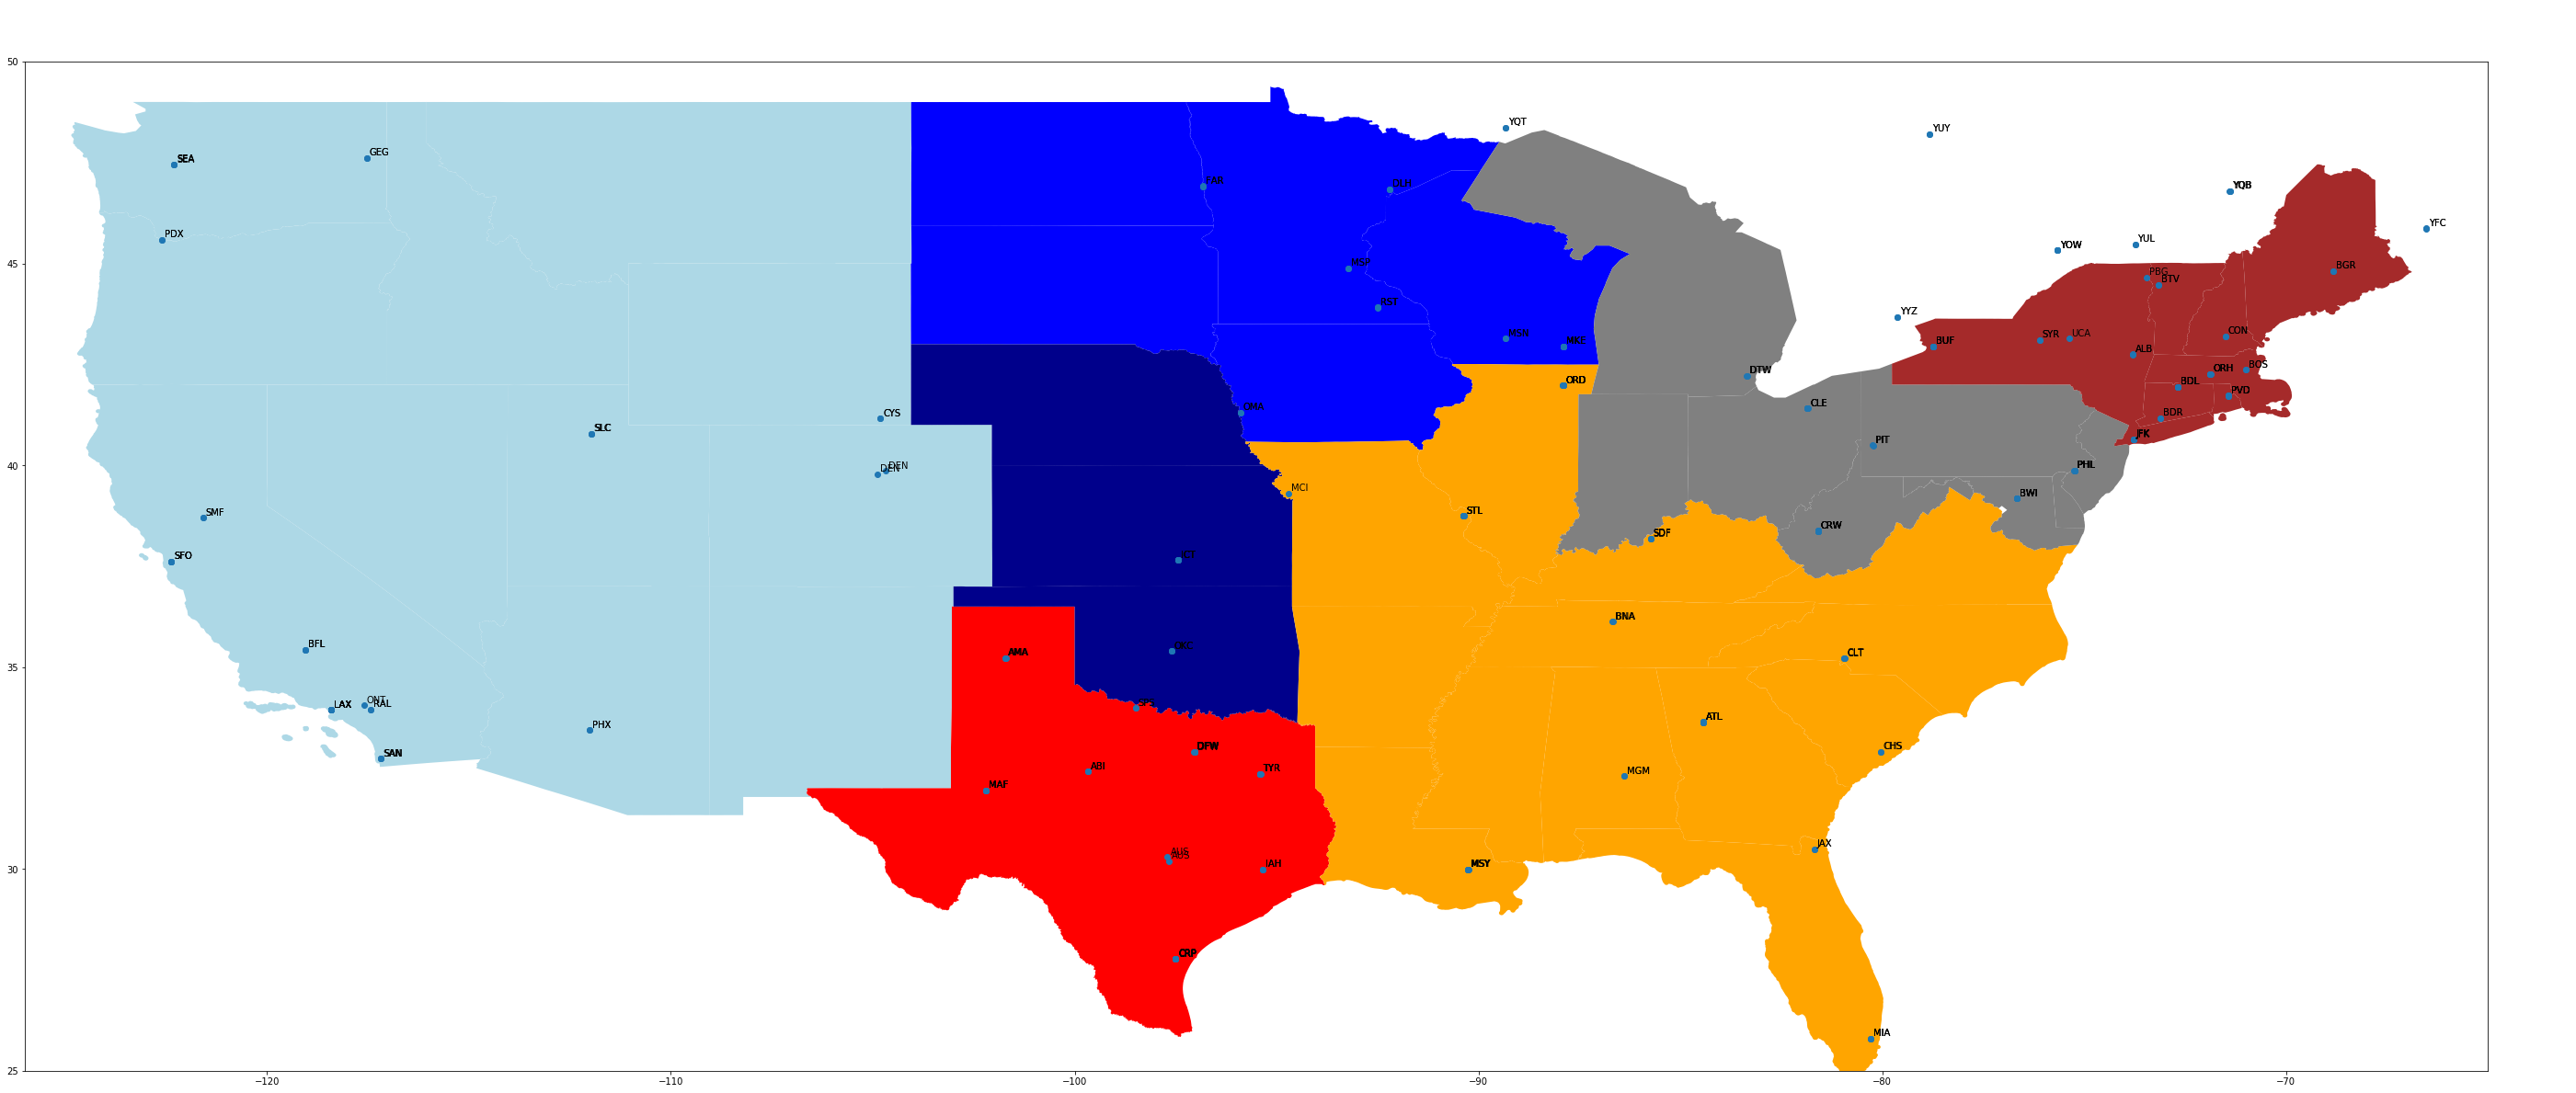

In [118]:
base = nerc_gdf.plot(figsize=(48,24),color="white")
base = nerc_gdf[nerc_gdf.NERCarea=="WECC"].plot(ax=base,color="lightblue")
base = nerc_gdf[nerc_gdf.NERCarea=="ERCOT"].plot(ax=base,color="red")
base = nerc_gdf[nerc_gdf.NERCarea=="MRO"].plot(ax=base,color="blue")
base = nerc_gdf[nerc_gdf.NERCarea=="SPP"].plot(ax=base,color="darkblue")
base = nerc_gdf[nerc_gdf.NERCarea=="SERC"].plot(ax=base,color="orange")
base = nerc_gdf[nerc_gdf.NERCarea=="RF"].plot(ax=base,color="grey")
base = nerc_gdf[nerc_gdf.NERCarea=="NPCC"].plot(ax=base,color="brown")
base = cities.plot(ax=base)
base.set_xlim(-126,-65)
base.set_ylim(25,50)
for x,y,t in zip(cities.geometry.x,cities.geometry.y,cities.index):
    base.annotate(t,xy=(x,y),xytext=(3,3),textcoords="offset points")
base.plot()
plt.savefig("lmtfmap.png")